# Implementación de capas personalizadas

Una capa personalizada en general se utiliza para construir modelos que contienen bloques muy repetitivos de capas, que es conveniente por motivos de granularidad que se traten como un bloque solo, en una red de más alto nivel. Es posible también crear una capa sin pesos con el siguiente ejemplo

```python 
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))
```

In [ ]:
Una capa de este estilo se utiliza con la api sequencial, funcional y de subclases de Keras

```python
import tensorflow as tf

class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal"
        )
        self.bias = self.add_weight(
            name="bias",
            shape=[self.units],
            initializer="zeros"
        )
    
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "units": self.units,
            "activation": tf.keras.activations.serialize(self.activation)
        }

```

Esta clase MyDense es una implementación personalizada de una capa densa en Keras que sigue el patrón estándar para crear capas personalizadas:
##### Estructura de la clase:
1. Constructor (__init__):
-  Recibe hiperparámetros (units, activation)
-  Maneja argumentos estándar con **kwargs
-  Convierte la activación a función usando tf.keras.activations.get()
2. Método build():
- Crea los pesos (kernel y bias) cuando se conoce la forma de entrada
- Se ejecuta automáticamente la primera vez que se usa la capa
- Llama al build() del padre al final
3. Método call():
- Define la operación forward pass: X @ kernel + bias
- Aplica la función de activación al resultado
4. Método get_config():
- Permite serialización para guardar/cargar modelos
- Incluye configuración completa de la activación
5. Ventajas:
- Reutilizable: Se puede usar como cualquier capa estándar de Keras
- Personalizable: Permite modificar completamente el comportamiento
- Serializable: Compatible con el guardado de modelos
- Eficiente: Sigue las mejores prácticas de Keras

Para crear una capa con múltiples inputs, el parámetros al método call() tiene que ser una tupla que contiene todos los inputs, para crear una capa con múltiples outpus, este método debe devolver una lista de outputs

```python
    class MyMultiLayer(tf.keras.layers.Layer):
        def call(self, X):
            X1, X2 = X
            return X1 + X2, X1 * X2, X1 / X2
```

Una clase con esta característica solo se puede usar con la subclassing api de Keras, la sequential solo soporta capas de un input y output

Si tu capa necesita comportamiento diferente entre entrenamiento y pruebas (Dropout, BatchNormalization), debes agregar un argumento training al método call(). Este ejemplo es una capa que agregue ruido gaussiano solo durante entrenamiento (Keras ya tiene tf.keras.layers.GaussianNoise).

``` python
    class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
    
    def call(self, X, training=False):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
```

# Custom Model

Para crear un modelo personalizado hay que hacer una subclase de tf.keras.Model, crear capas y variables en el constructor e implementar el método call con lo que se quiera que haga el modelo

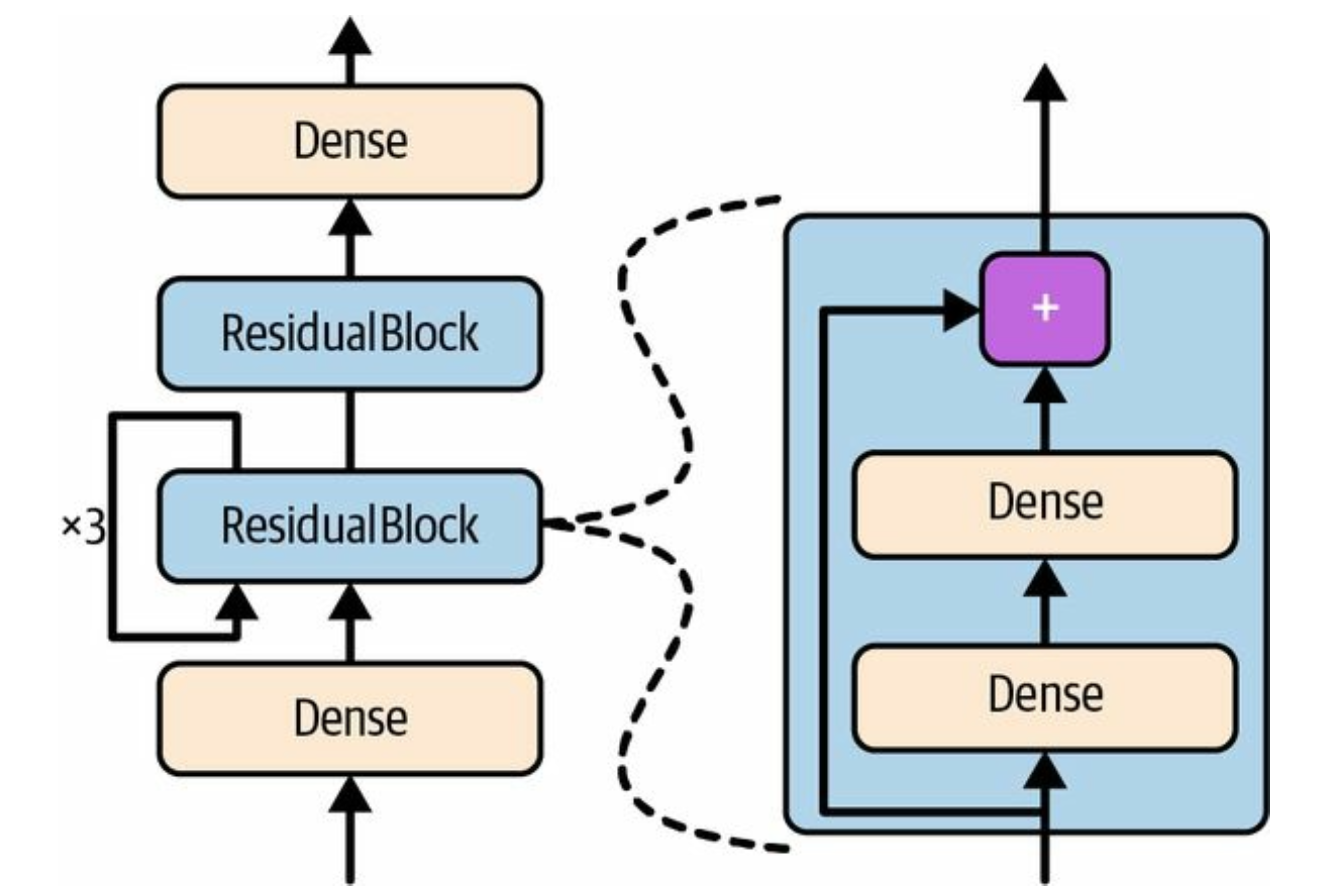

Las entradas pasan por una capa densa, luego por un bloque residual (dos capas densas + suma), luego por el mismo bloque residual tres veces más, luego por un segundo bloque residual, y finalmente por una capa densa de salida.
Para implementar esto, es mejor crear primero una capa ResidualBlock ya que se reutiliza.

```python
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [
            tf.keras.layers.Dense(
                n_neurons, 
                activation="relu",
                kernel_initializer="he_normal"
            )
            for _ in range(n_layers)
        ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
```

Esta capa es especial porque contiene otras capas. Keras maneja esto automáticamente: detecta que hidden contiene objetos trackable (capas) y agrega sus variables a la lista de variables de la capa. Ahora usaremos la API de subclasificación para definir el modelo.

```python
    import tensorflow as tf

class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(
            30, 
            activation="relu",
            kernel_initializer="he_normal"
        )
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)
    
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):  # Se ejecuta 4 veces
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)
```

Este modelo se usa como cualquier otro (compile, fit, evaluate, predict). Para guardar/cargar con save() y load_model(), debes implementar get_config() en ambas clases. Alternativamente, usa save_weights() y load_weights().
La clase Model hereda de Layer, por lo que los modelos se usan como capas pero con funcionalidades extra: compile(), fit(), evaluate(), predict(), get_layer(), save(), etc.

# Losses and Metrics Based on Model Internals

Las pérdidas personalizadas anteriores se basaban en etiquetas y predicciones. A veces querrás pérdidas basadas en otras partes del modelo (pesos, activaciones) para regularización o monitoreo.
Para esto, calcula la pérdida basada en cualquier parte del modelo y pásala a add_loss().
Ejemplo: modelo MLP con 5 capas ocultas + salida auxiliar que reconstruye la entrada. La pérdida de reconstrucción (MSE entre reconstrucción y entrada) se agrega a la pérdida principal para preservar información y mejorar generalización. También se puede agregar métricas con add_metric().

```python
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [
            tf.keras.layers.Dense(
                30, 
                activation="relu",
                kernel_initializer="he_normal"
            )
            for _ in range(5)
        ]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(
            name="reconstruction_error"
        )
    
    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)
    
    def call(self, inputs, training=False):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        
        return self.out(Z)
```

## 1. Constructor (`__init__`)
- **Propósito**: Crea la arquitectura de la DNN
- **Componentes**:
  - 5 capas densas ocultas con 30 neuronas cada una
  - 1 capa densa de salida
  - Métrica `Mean` para rastrear error de reconstrucción

## 2. Método `build()`
- **Propósito**: Crea la capa de reconstrucción
- **¿Por qué aquí?**: El número de unidades debe ser igual al número de entradas
- **Cuándo se ejecuta**: Cuando se conoce la forma de entrada

## 3. Método `call()` - Procesamiento Principal
- **Paso 1**: Procesa entradas a través de las 5 capas ocultas
- **Paso 2**: Pasa resultado por la capa de reconstrucción
- **Paso 3**: Calcula pérdida de reconstrucción (MSE)
- **Paso 4**: Agrega pérdida al modelo con factor 0.05

## 4. Método `call()` - Regularización
- **Escalado**: Factor 0.05 evita que domine la pérdida principal
- **Hiperparámetro**: Ajustable según necesidades
- **Propósito**: Balance entre tarea principal y reconstrucción

## 5. Método `call()` - Métricas (Solo Entrenamiento)
- **Actualización**: Métrica de reconstrucción durante training
- **Simplificación**: `self.add_metric(recon_loss)` es suficiente
- **Automático**: Keras rastrea la media automáticamente

## 6. Método `call()` - Salida Final
- **Procesamiento**: Pasa salida de capas ocultas a capa de salida
- **Retorno**: Resultado de la capa de salida

## Características Clave
- **Pérdida personalizada**: Basada en reconstrucción de entrada
- **Regularización**: Mejora generalización
- **Métricas**: Monitoreo del error de reconstrucción
- **Flexibilidad**: Hiperparámetros ajustables